In [1]:
import requests
import zipfile
import io
import os

def download_and_extract_zip(url, target_dir):
    # Make a GET request to the URL
    response = requests.get(url)
    
    # Raise an exception for a non-200 status code
    response.raise_for_status()
    
    # Create a BytesIO object from the response content
    zip_content = io.BytesIO(response.content)
    
    # Open the ZIP file
    with zipfile.ZipFile(zip_content, 'r') as zip_ref:
        # Extract all contents to the target directory
        zip_ref.extractall(target_dir)
    
    print("Extraction complete.")

# URL of the ZIP file
zip_url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9sxpkmm8xn-1.zip"

# Directory where you want to extract the contents
target_directory = "./data"

# Check if the target directory already contains the extracted files
if not os.path.exists(target_directory):
    os.makedirs(target_directory)
    print("Directory created.")
    
    # Call the function to download and extract the ZIP file
    try:
        download_and_extract_zip(zip_url, target_directory)
    except requests.exceptions.RequestException as e:
        print(f"Failed to download and extract ZIP file: {e}")
else:
    print("Directory already exists. Skipping download and extraction.")


Directory already exists. Skipping download and extraction.


In [2]:
import pandas as pd

# Path to the CSV file
csv_file_path = "./data/A Curated Hate Speech Dataset/HSData/0_RawData/data_huang_devansh.csv"

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame to check if it's loaded correctly
df.head()

,Content,Label
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


In [3]:
# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Display the label counts
print("Label Counts:")
print(label_counts)

Label Counts:
Label
0    708641
1    133694
Name: count, dtype: int64


## Data Preprocessing

1. Remove multiple spaces, hyperlinks, user mentions, emojis, and emoticons converted to text, and removed new line characters
2. Removing date and time values
3. Removing accented numbers and characters (e.g., ^ea, or ^12)
4. The remaining numbers are converted to words
5. Removing ampersands from the beginning of words
6. Removing the following characters (_"\-;%()|+&=*%.,!?:#$@[]/) from the text

In [4]:
import re

def preprocess_text(text):
    # Check if the input is a non-null string
    if isinstance(text, str) and not pd.isnull(text):
        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)

        # Remove hyperlinks
        text = re.sub(r'http\S+', '', text)

        # Remove user mentions (assuming mentions start with @)
        text = re.sub(r'@\w+', '', text)

        # Remove emojis and emoticons
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   # Add more ranges as needed
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        # Remove new line characters
        text = text.replace('\n', '')

        return text
    else:
        # Return an empty string for NaN values
        return ''

# Create a new DataFrame with preprocessed content
df_preprocessed = pd.DataFrame({
    'Content': df['Content'].apply(preprocess_text),
    'Label': df['Label']
})

# Display the first few rows of the new DataFrame
df_preprocessed.head()

,Content,Label
0,`- This is not ``creative``. Those are the dic...,0
1,` :: the term ``standard model`` is itself les...,0
2,"True or false, the situation as of March 2002...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


In [5]:
from word2number import w2n  # Library for converting numbers to words
from unidecode import unidecode  # Library for removing accented characters

# Function to remove date and time values
def remove_date_time(text):
    # Implement your logic to remove date and time values
    # For example, you can use regular expressions to identify and remove them
    # Here's a simple example that removes strings with digits and colons
    return re.sub(r'\b\d{1,2}:\d{2}\b|\b\d{1,2}/\d{1,2}/\d{2,4}\b', '', text)

# Function to remove accented numbers and characters
def remove_accented_chars(text):
    return unidecode(text)

# Function to convert remaining numbers to words
def convert_numbers_to_words(text):
    # Replace numerical values with their word representations
    words = []
    for word in text.split():
        try:
            words.append(w2n.word_to_num(word))
        except ValueError:
            # Handle the case where w2n.word_to_num raises a ValueError
            words.append(word)
        except IndexError:
            # Handle the case where the list is empty
            pass
    return ' '.join(map(str, words))

# Function to remove ampersands from the beginning of words
def remove_ampersands(text):
    return re.sub(r'\b&(\w+)\b', r'\1', text)

# Function to remove specified characters from the text
def remove_special_characters(text):
    special_chars = r'_"\\;%\(\)|\+`&=*%,.!?:#$@[\]/-'
    return re.sub('[' + special_chars + ']', '', text)

# Apply the defined functions in sequence to the "Content" column
df_preprocessed['Content'] = df_preprocessed['Content'].apply(remove_date_time)
df_preprocessed['Content'] = df_preprocessed['Content'].apply(remove_accented_chars)
df_preprocessed['Content'] = df_preprocessed['Content'].apply(convert_numbers_to_words)
df_preprocessed['Content'] = df_preprocessed['Content'].apply(remove_ampersands)
df_preprocessed['Content'] = df_preprocessed['Content'].apply(remove_special_characters)

# Save the new DataFrame to a CSV file
df_preprocessed.to_csv('preprocessed_dataset.csv', mode='w', index=False)

# Display the first few rows of the new DataFrame
df_preprocessed.head()

,Content,Label
0,This is not creative Those are the dictionary...,0
1,the term standard model is itself less NPOV ...,0
2,True or false the situation as of March 2002 w...,0
3,Next maybe you could work on being less condes...,0
4,This page will need disambiguation,0


In [6]:
from sklearn.model_selection import train_test_split

# Assuming 'df_preprocessed' is your DataFrame with the preprocessed content and labels
X = df_preprocessed['Content']
y = df_preprocessed['Label']

# 60% Train 20% Test 20% Validate
# Split the data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Models

### Basic Model

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming X_train_temp, y_train_temp, X_validate, y_validate, X_test, and y_test are available
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_validate_sequences = tokenizer.texts_to_sequences(X_validate)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for the padding token

max_sequence_length = 100  # Adjust as needed
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_validate_padded = pad_sequences(X_validate_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

2023-10-08 22:52:05.580731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 22:52:05.580758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 22:52:05.580792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 22:52:05.587419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout

# Assuming vocab_size, embedding_dim, max_sequence_length, and num_classes are defined

model = Sequential()

model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          37690300  
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 128)               1280128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

2023-10-08 22:52:31.579801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-08 22:52:31.585472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-08 22:52:31.585822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_validate_padded, y_validate))

loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Basic Model Test Accuracy: {accuracy}')

model.save("model.h5")


Epoch 1/10


2023-10-08 22:52:32.452642: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-08 22:52:33.243267: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7feac40c0fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 22:52:33.243290: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2023-10-08 22:52:33.246333: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 22:52:33.257822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-08 22:52:33.321178: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15794/15794 [==============================] - 153s 10ms/step - loss: 0.2573 - accuracy: 0.8954 - val_loss: 0.2141 - val_accuracy: 0.9108
Epoch 2/10
15794/15794 [==============================] - 109s 7ms/step - loss: 0.1599 - accuracy: 0.9376 - val_loss: 0.2105 - val_accuracy: 0.9178
Epoch 3/10
15794/15794 [==============================] - 107s 7ms/step - loss: 0.1116 - accuracy: 0.9584 - val_loss: 0.2419 - val_accuracy: 0.9198
Epoch 4/10
15794/15794 [==============================] - 107s 7ms/step - loss: 0.0873 - accuracy: 0.9677 - val_loss: 0.2391 - val_accuracy: 0.9205
Epoch 5/10
15794/15794 [==============================] - 107s 7ms/step - loss: 0.0718 - accuracy: 0.9729 - val_loss: 0.2719 - val_accuracy: 0.9188
Epoch 6/10
15794/15794 [==============================] - 106s 7ms/step - loss: 0.0625 - accuracy: 0.9759 - val_loss: 0.3200 - val_accuracy: 0.9213
Epoch 7/10
15794/15794 [==============================] - 106s 7ms/step - loss: 0.0559 - accuracy: 0.9777 - val_loss: 0.36

/home/zschaub/miniconda3/envs/content/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5265/5265 [==============================] - 3s 614us/step


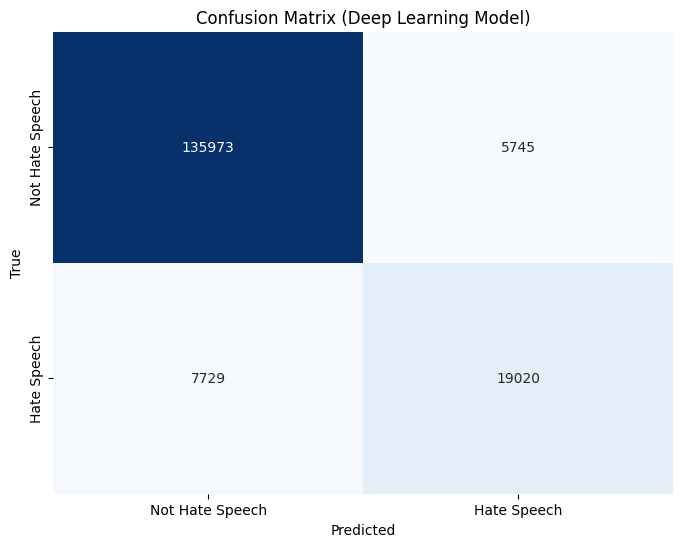

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    141718
           1       0.77      0.71      0.74     26749

    accuracy                           0.92    168467
   macro avg       0.86      0.84      0.85    168467
weighted avg       0.92      0.92      0.92    168467



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype('int')

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Hate Speech', 'Hate Speech'],
            yticklabels=['Not Hate Speech', 'Hate Speech'])
plt.title('Confusion Matrix (Deep Learning Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes))


### Rules Based Model

In [11]:
import os
import urllib.request

# Define the folder name
folder_name = 'ruleset'

# Check if the folder exists, and create it if not
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created.")

# Define the URLs of the JSON files to download
json_files = [
    ('cad_rules.json', 'https://raw.githubusercontent.com/ChrisIsKing/Rule-By-Example/main/data/rulesets/cad_rules.json'),
    ('hate_abuse_sample.json', 'https://raw.githubusercontent.com/ChrisIsKing/Rule-By-Example/main/data/rulesets/hate_abuse_sample.json'),
    ('hatexplain_rules.json', 'https://raw.githubusercontent.com/ChrisIsKing/Rule-By-Example/main/data/rulesets/hatexplain_rules.json')
]

# Download the JSON files if they don't exist
for file_name, url in json_files:
    file_path = os.path.join(folder_name, file_name)
    
    if not os.path.exists(file_path):
        print(f"Downloading {file_name}...")
        urllib.request.urlretrieve(url, file_path)
        print(f"{file_name} downloaded.")
    else:
        print(f"{file_name} already exists.")



cad_rules.json already exists.
hate_abuse_sample.json already exists.
hatexplain_rules.json already exists.


In [12]:
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define the folder name
folder_name = 'ruleset'

# Check if the folder exists, and create it if not
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created.")

# Define the rulesets
ruleset_files = [
    'cad_rules.json',
    'hate_abuse_sample.json',
    'hatexplain_rules.json'
]

# Load rulesets into DataFrames
rulesets = {}
for ruleset_file in ruleset_files:
    ruleset_path = os.path.join(folder_name, ruleset_file)
    ruleset_name = os.path.splitext(ruleset_file)[0]  # Extract ruleset name without extension
    
    rules = pd.read_json(ruleset_path, typ='series').tolist()  # Load as a list of strings
    
    # Create a DataFrame with a 'rule' column
    ruleset_df = pd.DataFrame({'rule': rules})
    
    rulesets[ruleset_name] = ruleset_df

# Function to apply rules and make predictions
def apply_rules(ruleset, text):
    for rule in ruleset['rule']:
        if rule in text:
            return 1  # Violation
    return 0  # No violation

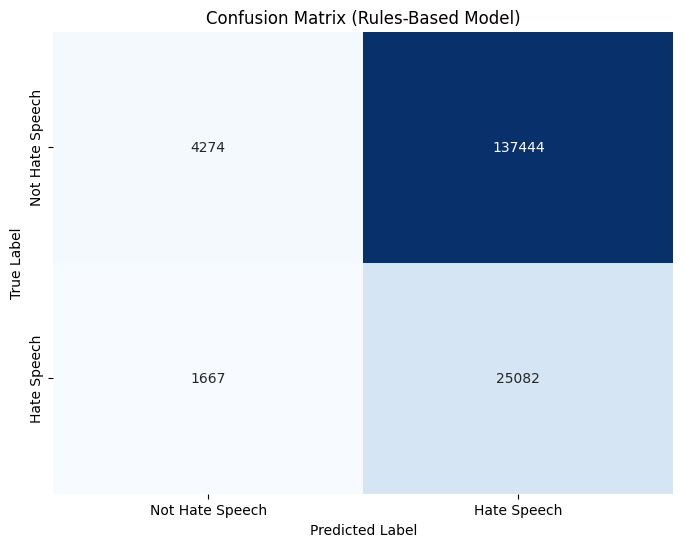

              precision    recall  f1-score   support

           0       0.72      0.03      0.06    141718
           1       0.15      0.94      0.27     26749

    accuracy                           0.17    168467
   macro avg       0.44      0.48      0.16    168467
weighted avg       0.63      0.17      0.09    168467



In [13]:
# Create a new DataFrame to store the results
df_rules = pd.DataFrame({'Content': X_test})
df_rules['Label'] = y_test

# Apply rulesets to df_rules and create predictions
for ruleset_name, ruleset_df in rulesets.items():
    df_rules[ruleset_name] = df_preprocessed["Content"].apply(lambda text: apply_rules(ruleset_df, text))

# Combine predictions from different rulesets
df_rules['rules_based_prediction'] = df_rules[rulesets.keys()].max(axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(df_rules['Label'], df_rules['rules_based_prediction'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Hate Speech', 'Hate Speech'],
            yticklabels=['Not Hate Speech', 'Hate Speech'])
plt.title('Confusion Matrix (Rules-Based Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print(classification_report(df_rules['Label'], df_rules['rules_based_prediction']))


### Dual Architecture

In [14]:
from tensorflow.keras.models import load_model

# Step 1: Apply Rules-Based Model
# Create a new DataFrame to store the results
df_results = pd.DataFrame({'Content': X_test})
df_results['Label'] = y_test

# Step 1: Apply Rules-Based Model
df_results['rules_based_prediction'] = X_test.apply(lambda text: apply_rules(ruleset_df, text))

# Step 2: Load your Deep Learning Model
deep_learning_model = load_model("model.h5")

# Assuming deep_learning_model.predict(X_test_padded) returns a 2D array of shape (168467, 1)
predictions_array = deep_learning_model.predict(X_test_padded).reshape(-1)  # Reshape to 1D array

# Add the predictions to the DataFrame
df_results['deep_learning_prediction'] = (predictions_array > 0.5).astype(int)

# Combine predictions from both models
df_results['final_prediction'] = df_results.apply(lambda row: row['deep_learning_prediction'] if row['rules_based_prediction'] == 1 else row['rules_based_prediction'], axis=1)

# Display the results DataFrame with predictions
df_results.head()

5265/5265 [==============================] - 3s 587us/step


,Content,Label,rules_based_prediction,deep_learning_prediction,final_prediction
216606,Hi I didn't add mile rather all the others bes...,0,1,0,0
437798,,0,0,0,0
303068,Eleazar the son of Aaron is mentioned numerous...,0,1,0,0
695666,she always makes me laugh and I think she shou...,0,1,0,0
532460,You s m e l l Sorry but you s m e l l of w e e...,1,0,1,0


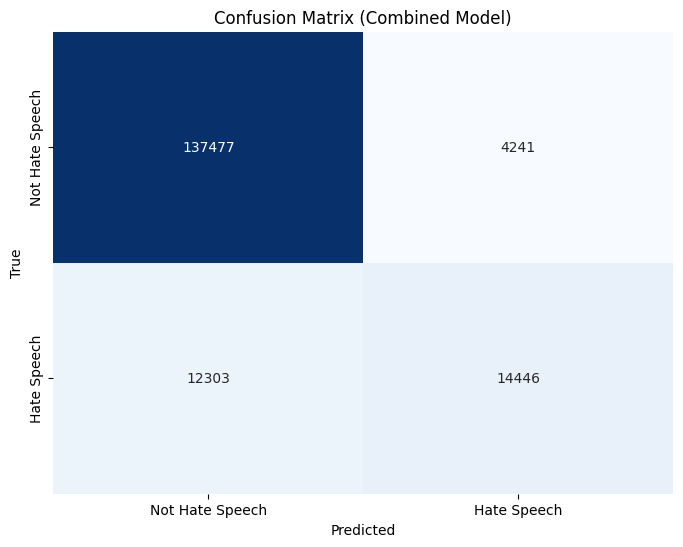

              precision    recall  f1-score   support

           0       0.92      0.97      0.94    141718
           1       0.77      0.54      0.64     26749

    accuracy                           0.90    168467
   macro avg       0.85      0.76      0.79    168467
weighted avg       0.89      0.90      0.89    168467



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

actual_labels = df_results['final_prediction']  # Replace 'actual_label' with the actual column name

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, df_results['final_prediction'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Hate Speech', 'Hate Speech'],
            yticklabels=['Not Hate Speech', 'Hate Speech'])
plt.title('Confusion Matrix (Combined Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_test, df_results['final_prediction']))
